In [1]:
# Import neccessary library
import numpy as np
import pandas as pd
from sklearn.neighbors import kneighbors_graph
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import ListedColormap

warnings.filterwarnings('ignore')

In [2]:
# Read in the dataset
movie = pd.read_csv("imdb.csv")

In [3]:
# Check out the dataset
movie.head()

,id,title,genres,averageRating,numVotes,releaseYear
0,tt5988370,Reis,"Biography, Drama",1.0,74179,2017
1,tt7221896,Cumali Ceber: Allah Seni Alsin,Comedy,1.0,39471,2017
2,tt13423846,321 Action,Drama,1.0,10222,2020
3,tt20255706,The Pogmentary,"Biography, Documentary, Sport",1.1,13799,2022
4,tt21403988,The Last Pharaoh,"Documentary, Drama, History",1.1,12044,2023


In [4]:
# Check out the shape of the dataset
movie.shape

(1000, 6)

In [5]:
# Check for null values in the dataset
movie.isnull().sum()

id               0
title            0
genres           0
averageRating    0
numVotes         0
releaseYear      0
dtype: int64

In [6]:
# Ensure every datapoint has a high number of reviews, to avoid films skewed by only a few bad reviews
movie.sort_values(by='numVotes').head()

,id,title,genres,averageRating,numVotes,releaseYear
752,tt1388418,Deportees,"Action, Comedy, Drama",4.9,10003,2007
680,tt1930294,Black Rock,"Horror, Thriller",4.8,10005,2012
506,tt4651410,Precious Cargo,"Action, Comedy, Thriller",4.6,10016,2016
15,tt1309000,Dream.net,"Comedy, Romance, Sport",1.3,10026,2009
957,tt0156182,Wishmaster 2: Evil Never Dies,"Fantasy, Horror",5.1,10027,1999


In [7]:
# Drop unneeded column 'id', which has no predicting value
movie.drop(columns=['id', 'title'], inplace=True)

In [8]:
movie.head()

,genres,averageRating,numVotes,releaseYear
0,"Biography, Drama",1.0,74179,2017
1,Comedy,1.0,39471,2017
2,Drama,1.0,10222,2020
3,"Biography, Documentary, Sport",1.1,13799,2022
4,"Documentary, Drama, History",1.1,12044,2023


In [9]:
movie.columns = ['Genres', 'AvgRating', 'NumVotes', 'ReleaseYear']

In [10]:
movie.head()

,Genres,AvgRating,NumVotes,ReleaseYear
0,"Biography, Drama",1.0,74179,2017
1,Comedy,1.0,39471,2017
2,Drama,1.0,10222,2020
3,"Biography, Documentary, Sport",1.1,13799,2022
4,"Documentary, Drama, History",1.1,12044,2023


In [11]:
# Check the range of years covered in this project
movie['ReleaseYear'].describe()

count    1000.000000
mean     2009.387000
std        10.705505
min      1957.000000
25%      2003.000000
50%      2011.000000
75%      2018.000000
max      2024.000000
Name: ReleaseYear, dtype: float64

In [12]:
# Check the range of scores movies received
movie['AvgRating'].describe()

count    1000.000000
mean        4.322800
std         0.893431
min         1.000000
25%         4.000000
50%         4.600000
75%         4.900000
max         5.200000
Name: AvgRating, dtype: float64

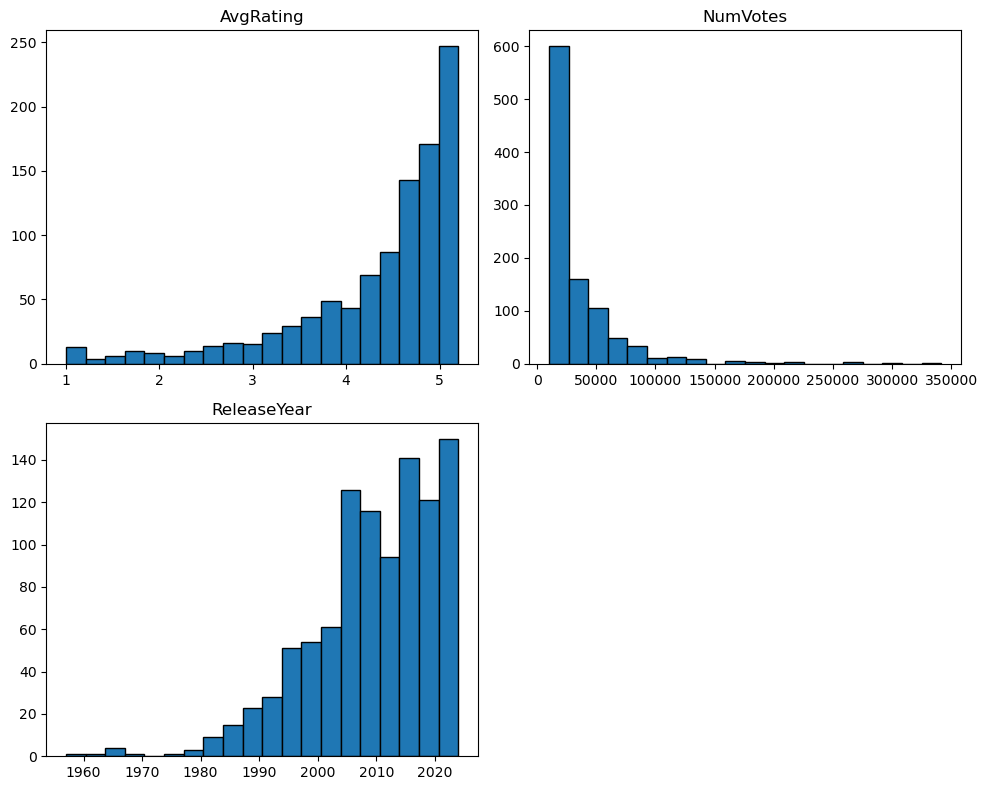

In [13]:
# Import libraries
import matplotlib.pyplot as plt

def plot_histograms(df):
    """
    Plot histograms for all numerical columns in a DataFrame without gridlines.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.

    Returns:
    None
    """
    numerical_columns = df.select_dtypes(include=['number']).columns
    df[numerical_columns].hist(bins=20, figsize=(10, 8), edgecolor='black', grid=False)
    plt.tight_layout()
    plt.show()
    
plot_histograms(movie)

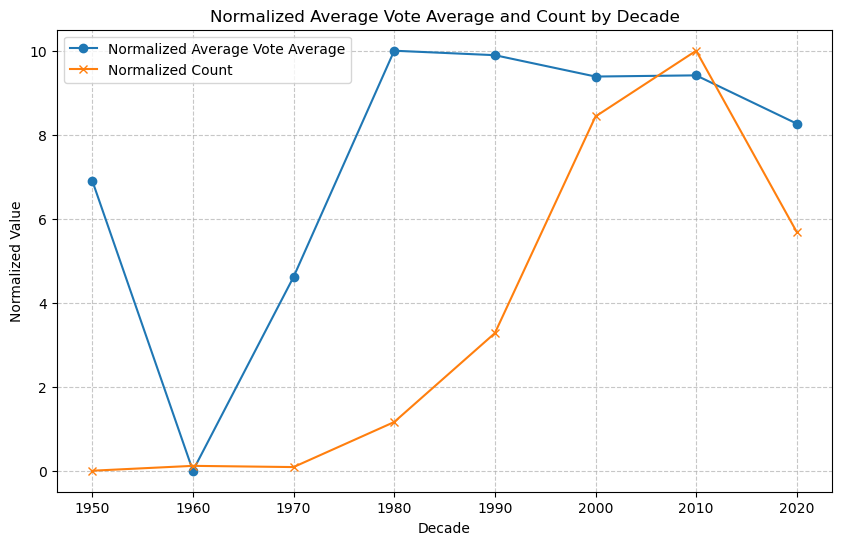

In [14]:
# Extract the decade from the release year
movie['Decade'] = movie['ReleaseYear'] // 10 * 10

# Group by decade and calculate mean vote average and count
grouped_data = movie.groupby('Decade').agg(AvgRating_mean=('AvgRating', 'mean'),
                                           AvgRating_count=('AvgRating', 'count'))

# Normalize the data
grouped_data['normalized_vote_average'] = (grouped_data['AvgRating_mean'] - grouped_data['AvgRating_mean'].min()) / \
                                          (grouped_data['AvgRating_mean'].max() - grouped_data['AvgRating_mean'].min()) * 10

grouped_data['normalized_count'] = (grouped_data['AvgRating_count'] - grouped_data['AvgRating_count'].min()) / \
                                   (grouped_data['AvgRating_count'].max() - grouped_data['AvgRating_count'].min()) * 10

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot the normalized average vote average
plt.plot(grouped_data.index, grouped_data['normalized_vote_average'], label='Normalized Average Vote Average', marker='o')

# Plot the normalized count
plt.plot(grouped_data.index, grouped_data['normalized_count'], label='Normalized Count', marker='x')

# Set the title and labels
plt.title('Normalized Average Vote Average and Count by Decade')
plt.xlabel('Decade')
plt.ylabel('Normalized Value')

# Add legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## Seemingly, from the 1980s to present the films in the bottom 1,000 are all about the same level of bad. Earlier movies, tended to be worse, according to this graph, but also very very rare, which is likely part of the reason. Additionally, there are no movies from before the 50s in the IMDB bottom 1,000.

In [15]:
# Split the 'genres' column and expand it into separate columns
data = movie['Genres'].str.split(', ', expand=True)

# One-hot encode the split data and sum by the first level of the index
dummies = pd.get_dummies(data.stack()).groupby(level=0).sum()

# Concatenate the one-hot encoded columns with the original DataFrame
movie2 = pd.concat([movie, dummies.add_prefix('Genre_')], axis=1)

# Drop the original 'genres' column
movie2.drop(columns='Genres', inplace=True)
movie2.head()

,AvgRating,NumVotes,ReleaseYear,Decade,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,...,Genre_Mystery,Genre_Reality-TV,Genre_Romance,Genre_Sci-Fi,Genre_Short,Genre_Sport,Genre_Talk-Show,Genre_Thriller,Genre_War,Genre_Western
0,1.0,74179,2017,2010,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,39471,2017,2010,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,10222,2020,2020,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.1,13799,2022,2020,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1.1,12044,2023,2020,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
values = movie2.drop(columns = ['AvgRating', 'NumVotes', 'ReleaseYear', 'Decade']).sum()
values.sort_values(ascending=False)

Genre_Comedy         392
Genre_Action         353
Genre_Drama          303
Genre_Horror         288
Genre_Thriller       215
Genre_Adventure      215
Genre_Crime          144
Genre_Mystery        135
Genre_Fantasy        118
Genre_Sci-Fi         116
Genre_Romance        115
Genre_Family          88
Genre_Music           21
Genre_Animation       20
Genre_Documentary     18
Genre_Sport           14
Genre_Biography       10
Genre_Musical         10
Genre_History          7
Genre_Reality-TV       6
Genre_War              5
Genre_Short            2
Genre_Game-Show        2
Genre_Western          2
Genre_Talk-Show        1
dtype: int64

In [17]:
# Drop boolean values that have less than x number of instances
movie2.drop([col for col, val in movie2.sum().items() if val < 100], axis=1, inplace=True)

In [18]:
movie2.head()

,AvgRating,NumVotes,ReleaseYear,Decade,Genre_Action,Genre_Adventure,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Fantasy,Genre_Horror,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller
0,1.0,74179,2017,2010,0,0,0,0,1,0,0,0,0,0,0
1,1.0,39471,2017,2010,0,0,1,0,0,0,0,0,0,0,0
2,1.0,10222,2020,2020,0,0,0,0,1,0,0,0,0,0,0
3,1.1,13799,2022,2020,0,0,0,0,0,0,0,0,0,0,0
4,1.1,12044,2023,2020,0,0,0,0,1,0,0,0,0,0,0


In [19]:
# Compute the correlation each column has with the target, rounded to 6 decimal places
correlation = movie2.corr()['AvgRating'].round(6)
correlation = correlation.drop('AvgRating')

# Sort the correlation values in descending order
correlation = correlation.sort_values(ascending=False)

# Print the number of rows and columns, along with the correlation
num_rows, num_columns = movie2.shape
print(f"Currently, {num_rows} movies are being analyzed, based on {num_columns} datapoints.")
print()
print(correlation)

Currently, 1000 movies are being analyzed, based on 15 datapoints.

Genre_Mystery      0.133448
Genre_Horror       0.117550
Genre_Thriller     0.101669
NumVotes           0.061891
Genre_Drama        0.030439
Genre_Crime        0.028122
Genre_Fantasy      0.010794
Genre_Adventure    0.005174
Genre_Romance      0.000274
Genre_Action      -0.004566
Genre_Comedy      -0.006280
Decade            -0.033504
ReleaseYear       -0.037647
Genre_Sci-Fi      -0.043170
Name: AvgRating, dtype: float64


In [20]:
movie2.head()

,AvgRating,NumVotes,ReleaseYear,Decade,Genre_Action,Genre_Adventure,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Fantasy,Genre_Horror,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller
0,1.0,74179,2017,2010,0,0,0,0,1,0,0,0,0,0,0
1,1.0,39471,2017,2010,0,0,1,0,0,0,0,0,0,0,0
2,1.0,10222,2020,2020,0,0,0,0,1,0,0,0,0,0,0
3,1.1,13799,2022,2020,0,0,0,0,0,0,0,0,0,0,0
4,1.1,12044,2023,2020,0,0,0,0,1,0,0,0,0,0,0


## I wanted to check if there was a difference in the movies that are classified by multiple genres vs single genre movies. TR

I think this may tell us more information on trends in popularity over time and what people may prefer to watch or not watch in this case.

In [21]:
if 'Genres' in movie.columns:
    # split the genres into separate lists. can tell if multiple genres in a movie if there is a comma. 
    movie['genres_list'] = movie['Genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
    
    # count the different types of movie genres.
    movie['genre_count'] = movie['genres_list'].apply(len)
    
    # separate the movies by single genre movies or movies with multiple genres.
    single_genre_movies = movie[movie['genre_count'] == 1]
    multi_genre_movies = movie[movie['genre_count'] > 1]
    
    # create comparison to compare information on single genre movies and multi-genre movies for visualizations **later**
    comparison = {
        "Single Genre Movies": {
            "Average Rating": single_genre_movies['AvgRating'].mean(),
            "Average Release Year": single_genre_movies['ReleaseYear'].mean(),
            "Count": single_genre_movies.shape[0],
        },
        "Multi-Genre Movies": {
            "Average Rating": multi_genre_movies['AvgRating'].mean(),
            "Average Release Year": multi_genre_movies['ReleaseYear'].mean(),
            "Count": multi_genre_movies.shape[0],
        }
    }
    
    # count the average number of genres movies have
    avg_genres_per_movie = movie['genre_count'].mean()
    
    from itertools import combinations
    from collections import Counter

    # split each genre cell up in order to track each genre separately
    movie['GenresList'] = movie['Genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
    movie['GenreCategory'] = movie['GenresList'].apply(lambda x: 'Single' if len(x) == 1 else 'Multi')
    
    # grouped data for visualizations
    grouped_data = movie.groupby('GenreCategory').agg({
        'AvgRating': 'mean',
        'NumVotes': 'sum', 
        'GenresList': 'count'  # count the number of movies in each genre
    }).rename(columns={'GenresList': 'MovieCount'}).reset_index()
    
    # count most common multi genre movies
    multi_genre_movies = movie[movie['GenreCategory'] == 'Multi']
    multi_genre_movies['GenreTuple'] = multi_genre_movies['GenresList'].apply(lambda x: tuple(sorted(x)))
    genre_combinations = Counter(multi_genre_movies['GenreTuple']) # make sure that order doesn't matter when counting cells, ie. comedy, action still counts the same as action, comedy
    most_common_combinations = genre_combinations.most_common(10)
    
    # display grouped data
    print("Comparison of Single-Genre vs Multi-Genre Movies:")
    print(grouped_data)

    # print most commmon genre pairing pairings and how many there are.
    print("\nMost Common Multi-Genre Groupings:")
    for genres, count in most_common_combinations:
        print(f"{genres}: {count}")

Comparison of Single-Genre vs Multi-Genre Movies:
  GenreCategory  AvgRating  NumVotes  MovieCount
0         Multi   4.340351  31392009         912
1        Single   4.140909   2833778          88

Most Common Multi-Genre Groupings:
(' Adventure', ' Comedy', 'Action'): 42
(' Mystery', ' Thriller', 'Horror'): 40
(' Thriller', 'Horror'): 34
(' Romance', 'Comedy'): 29
(' Comedy', ' Crime', 'Action'): 27
(' Adventure', ' Drama', 'Action'): 24
(' Comedy', ' Family', 'Adventure'): 22
(' Drama', ' Romance', 'Comedy'): 20
(' Adventure', ' Sci-Fi', 'Action'): 19
(' Thriller', 'Action'): 19


### Comparing Single and Multi-Genre Movies

The majority of the low rated movies fall under multiple genres. They are rated higher on average though. The majority of low rated movies are comedies, acition, adventure, thriller, mystery and horror. This could be because of how subjective comedy is and if a movie is well made but the humor isn't for you then you'll rate it lower. Perhaps horror is rated lower because of poorer special effects which can make a movie go from scary to cheesy?

### Some simple visualizations to demonstrate the differences

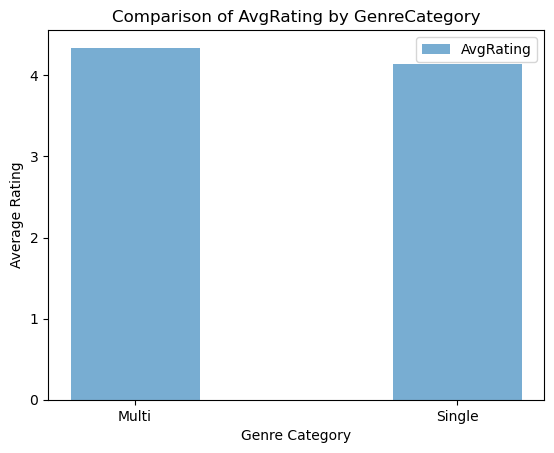

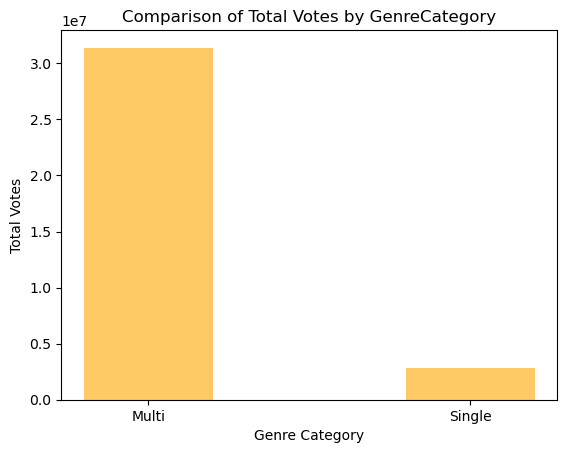

In [22]:
import matplotlib.pyplot as plt

# average rating by genre count
plt.bar(grouped_data['GenreCategory'], grouped_data['AvgRating'], alpha=0.6, width=0.4, align='center', label='AvgRating')


plt.ylabel('Average Rating')
plt.xlabel('Genre Category')
plt.title('Comparison of AvgRating by GenreCategory')
plt.legend()

plt.show()
# aevage number of votes based on genre count
plt.bar(grouped_data['GenreCategory'], grouped_data['NumVotes'], alpha=0.6, color='orange', width=0.4, align='center')
plt.ylabel('Total Votes')
plt.xlabel('Genre Category')
plt.title('Comparison of Total Votes by GenreCategory')
plt.show()


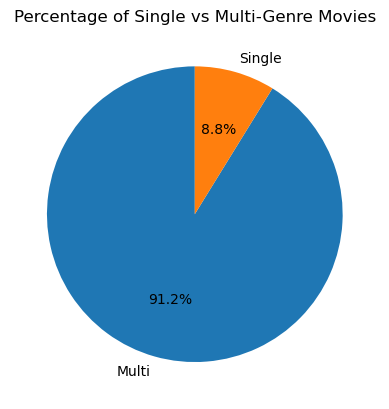

In [23]:
# pie chartMovie counts by genre type
grouped_data.set_index('GenreCategory')['MovieCount'].plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    title='Percentage of Single vs Multi-Genre Movies',
    ylabel='' 
)
plt.show()


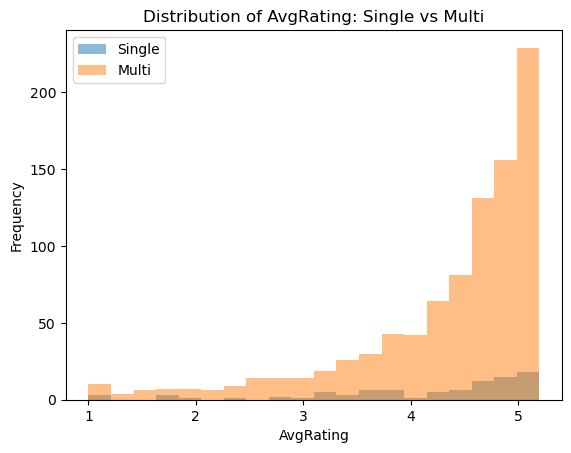

In [24]:
# AvgRating distribution for Single and Multi
movie[movie['GenreCategory'] == 'Single']['AvgRating'].plot.hist(alpha=0.5, label='Single', bins=20)
movie[movie['GenreCategory'] == 'Multi']['AvgRating'].plot.hist(alpha=0.5, label='Multi', bins=20)

plt.title('Distribution of AvgRating: Single vs Multi')
plt.xlabel('AvgRating')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### How has the popularity of these genres changed over time?

The following graph will show genre frequency over the years.

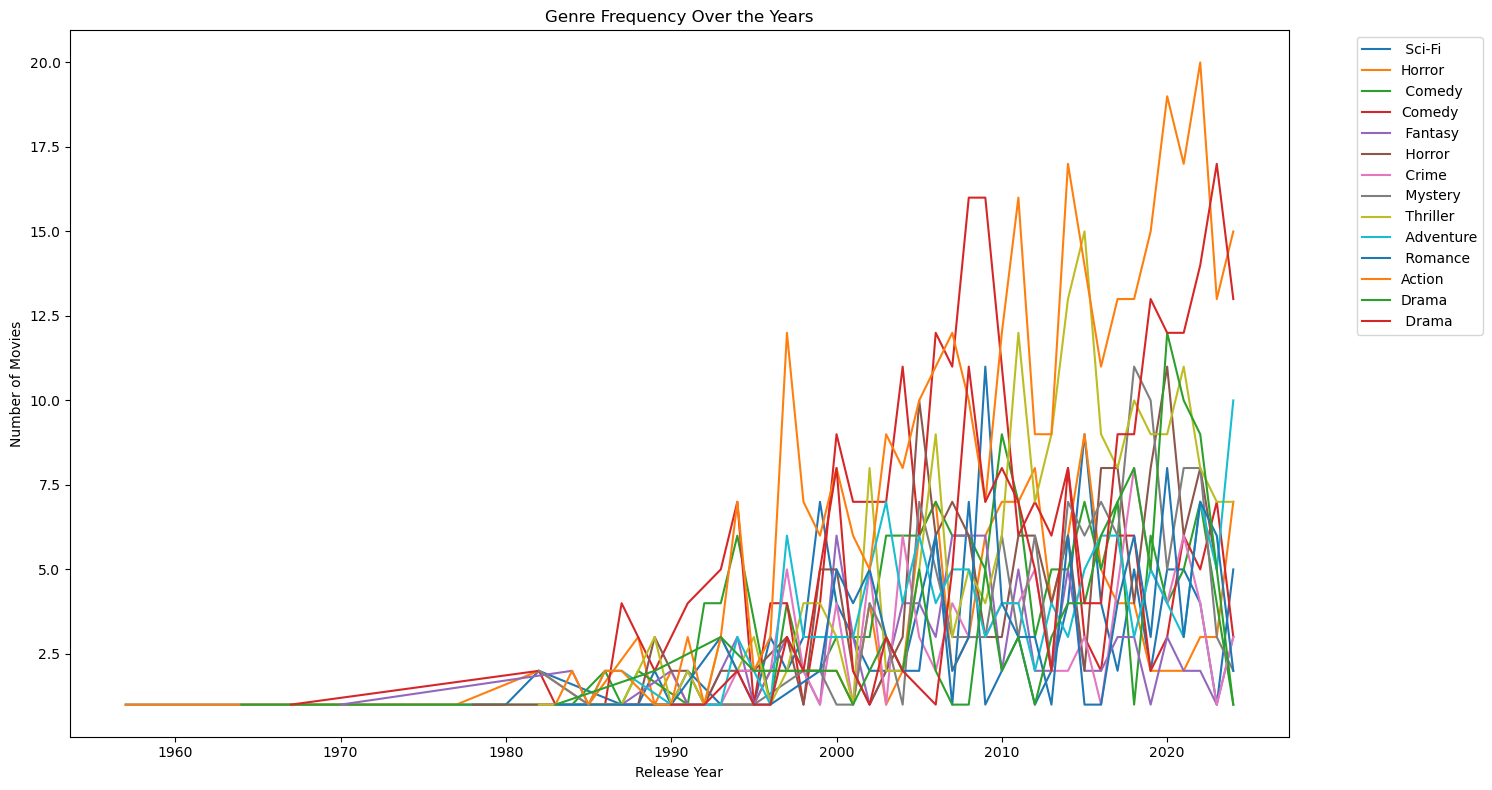

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Aggregate data for average ratings and votes by genre category
rating_vote_data = movie.groupby('GenreCategory').agg({
    'AvgRating': 'mean',
    'NumVotes': 'mean'
}).reset_index()

# Explode genres into separate rows for analysis
movie['GenresList'] = movie['Genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
movie_exploded = movie.explode('GenresList')

# Calculate the total number of movies for each genre
genre_totals = movie_exploded['GenresList'].value_counts()

# Filter to include only genres with 100 or more instances
valid_genres = genre_totals[genre_totals >= 100].index
filtered_movie_exploded = movie_exploded[movie_exploded['GenresList'].isin(valid_genres)]

# Calculate trends for the filtered genres
genre_trends = filtered_movie_exploded.groupby(['ReleaseYear', 'GenresList']).size().reset_index(name='Count')

# Plot the trends
plt.figure(figsize=(15, 8))

for genre in genre_trends['GenresList'].unique():
    genre_data = genre_trends[genre_trends['GenresList'] == genre]
    plt.plot(genre_data['ReleaseYear'], genre_data['Count'], label=genre)

plt.title('Genre Frequency Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### That's pretty difficult to read so i split each genre up onto their own graphs

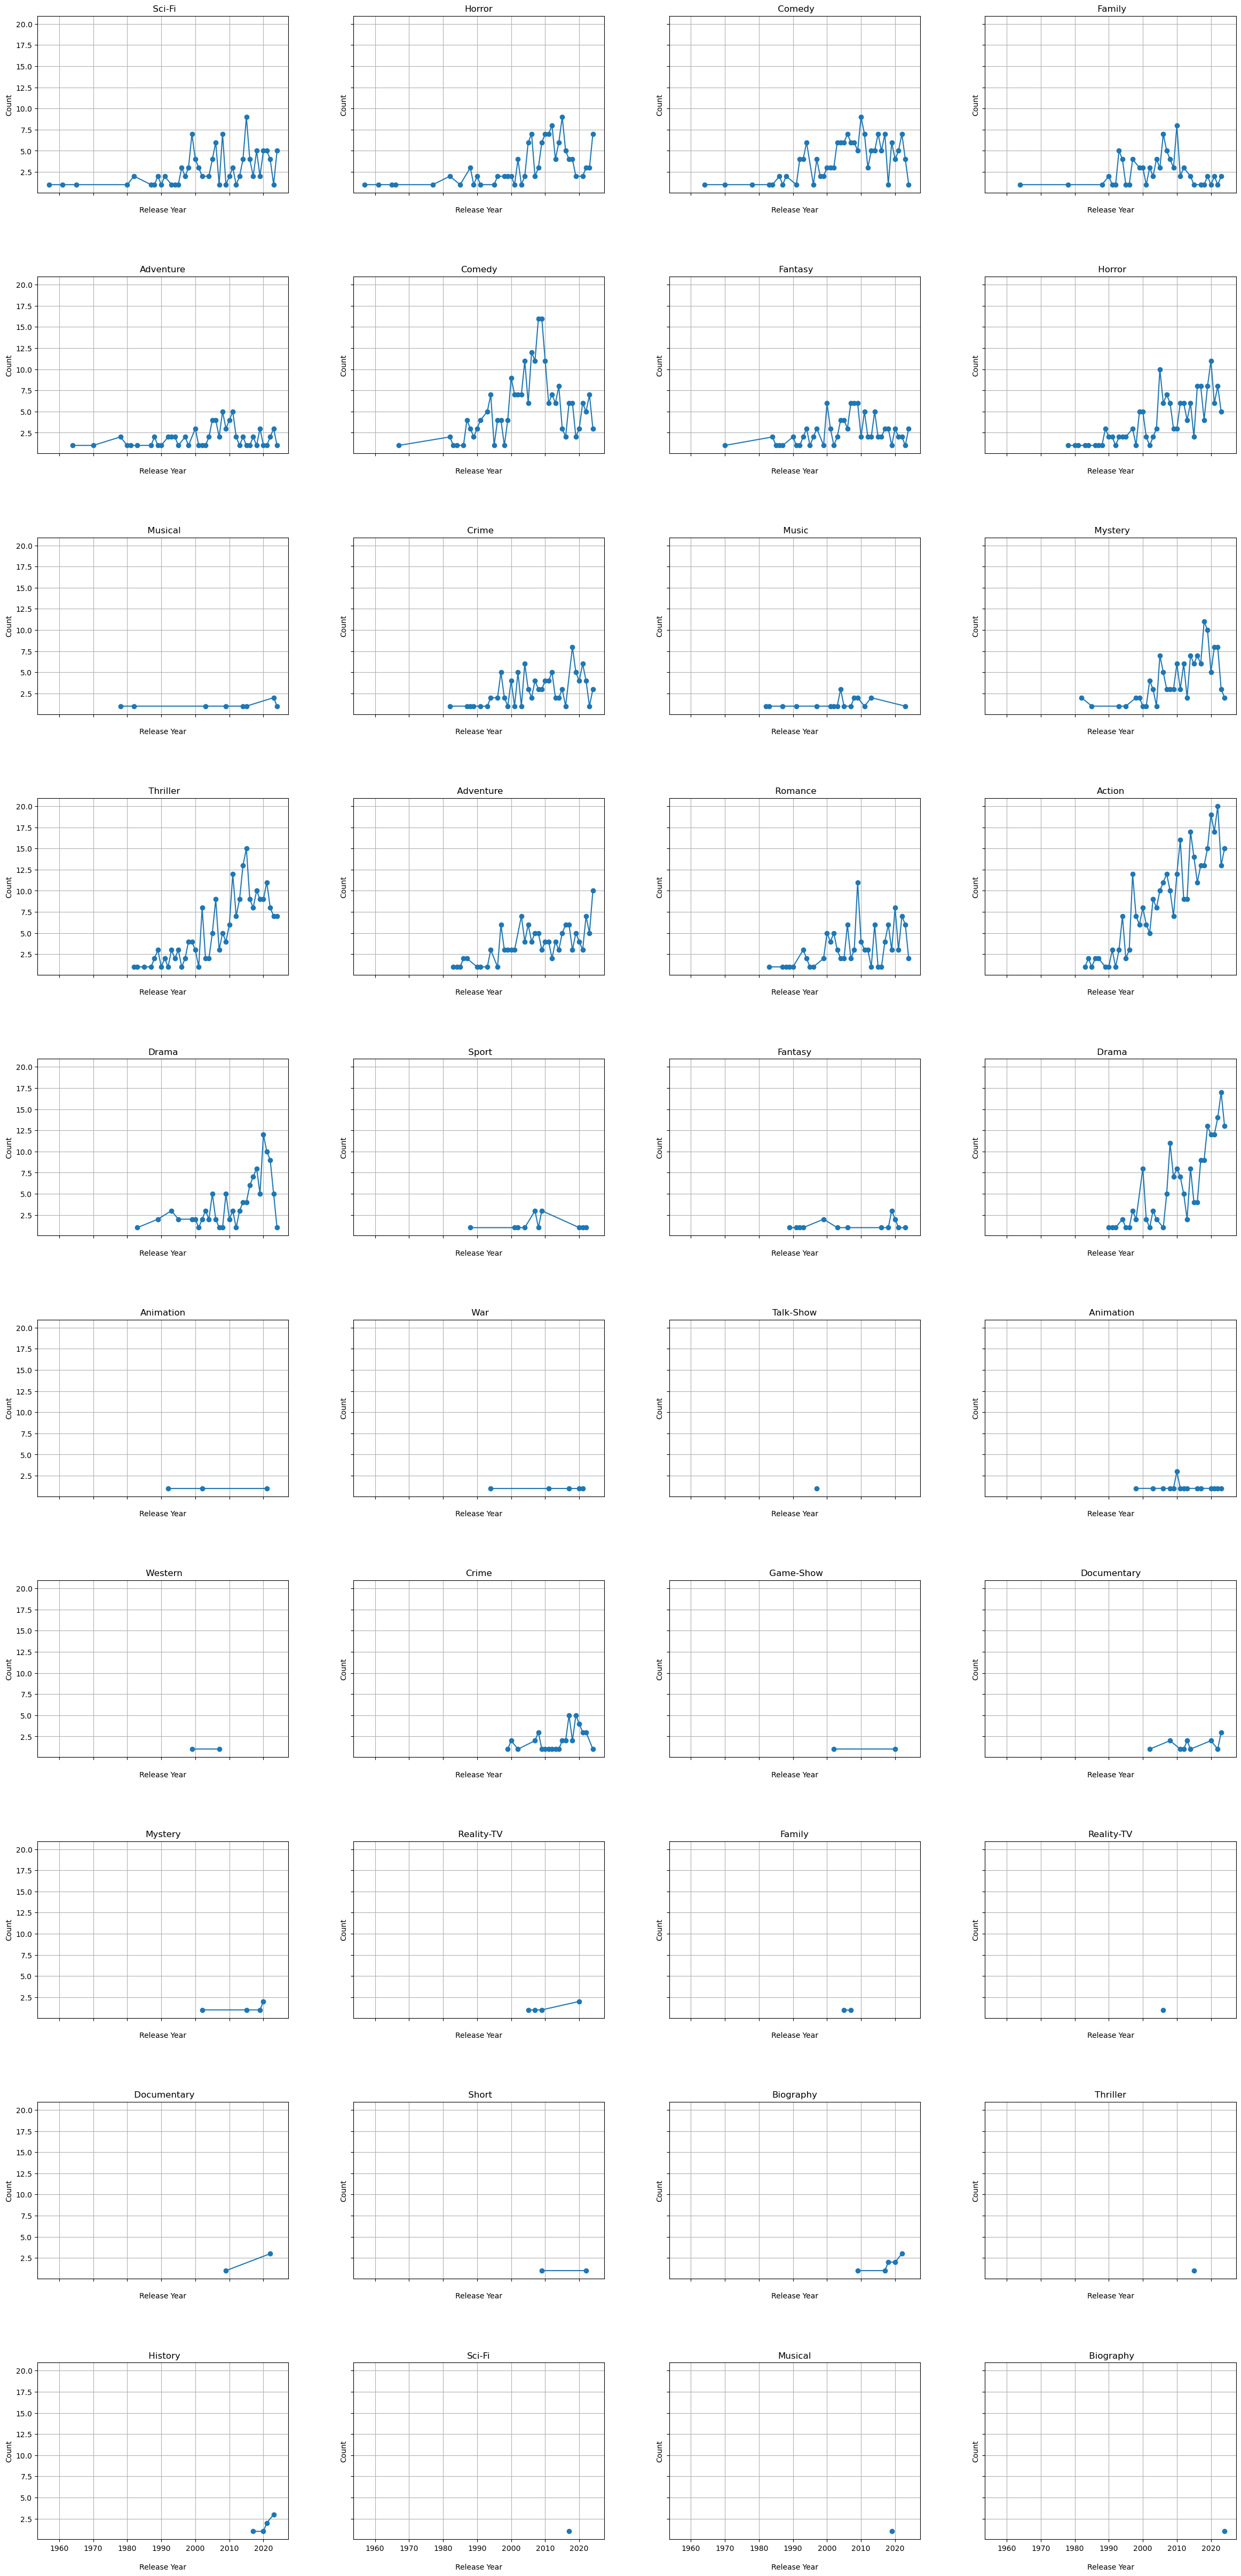

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

movie['GenresList'] = movie['Genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
movie_exploded = movie.explode('GenresList')  # makes list show each genre separately
genre_trends = movie_exploded.groupby(['ReleaseYear', 'GenresList']).size().reset_index(name='Count')

unique_genres = genre_trends['GenresList'].unique()

# grid layout
num_genres = len(unique_genres)
cols = 4  # Number of columns for the grid
rows = math.ceil(num_genres / cols)  # Calculate number of rows needed

# create subplots
fig, axes = plt.subplots(rows, cols, figsize=(25, rows * 5), sharex=True, sharey=True)

axes = axes.flatten()

# each genre's frequency
for i, genre in enumerate(unique_genres):
    ax = axes[i]
    genre_data = genre_trends[genre_trends['GenresList'] == genre]
    ax.plot(genre_data['ReleaseYear'], genre_data['Count'], marker='o')
    ax.set_title(genre)
    ax.set_xlabel('Release Year', labelpad=15)
    ax.set_ylabel('Count')
    ax.grid(True)
    
# 
for i in range(len(unique_genres), len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout(pad=7)
plt.show()


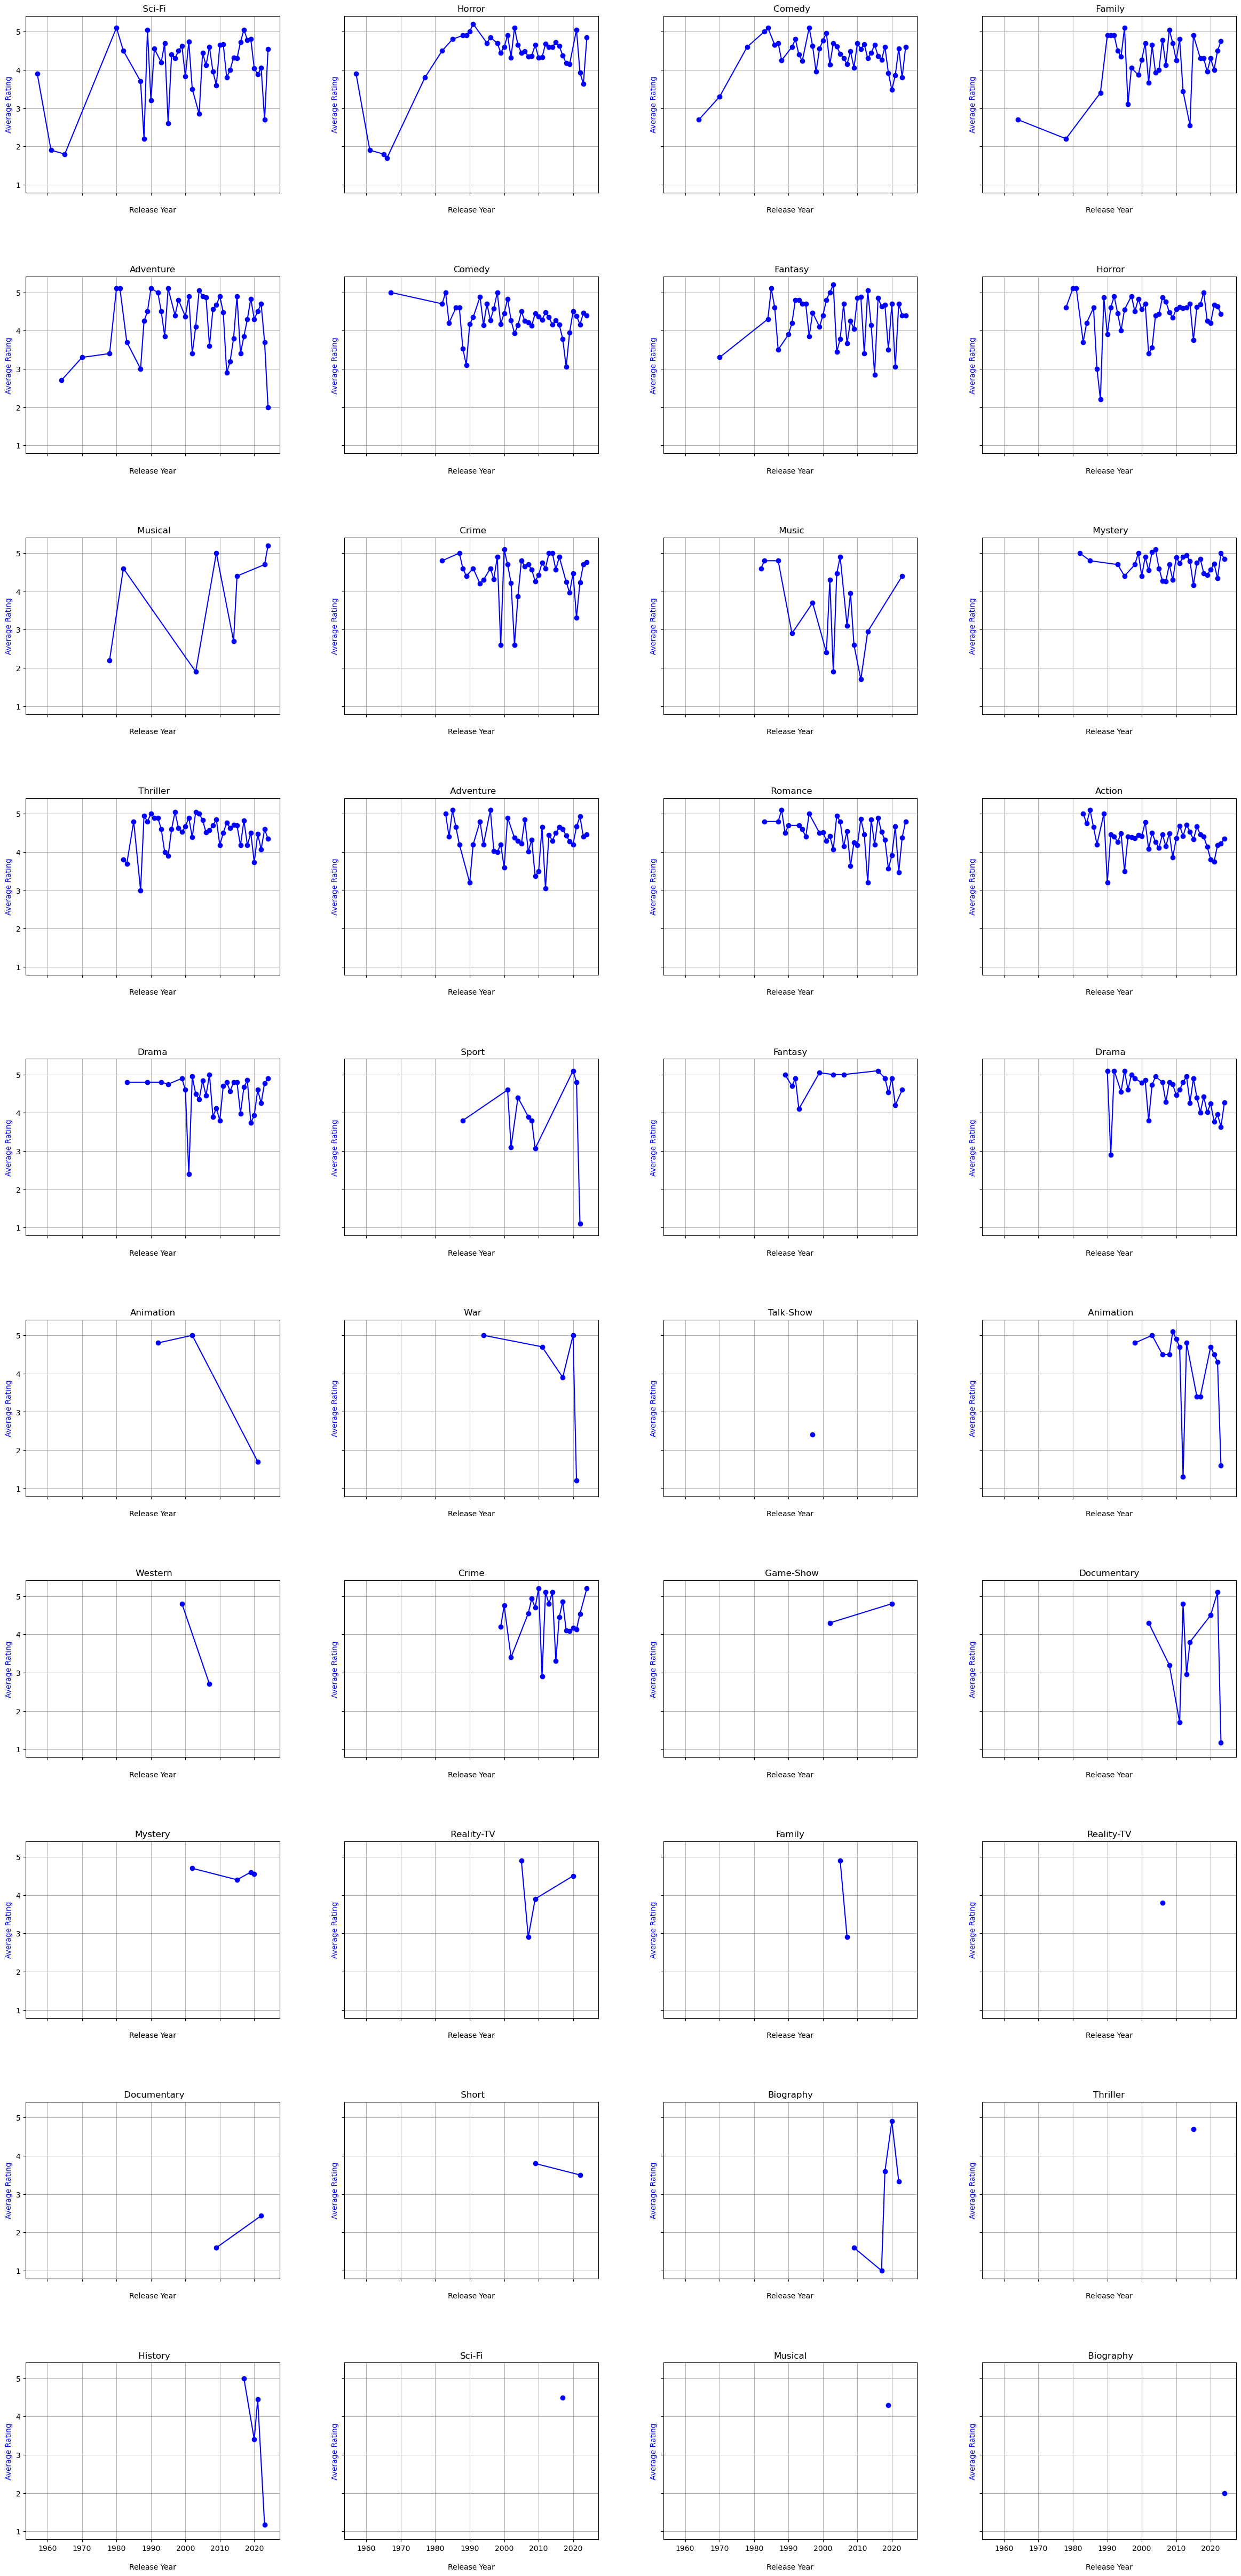

In [27]:

genre_trends = movie_exploded.groupby(['ReleaseYear', 'GenresList']).agg(
    AvgRating=('AvgRating', 'mean')
).reset_index()

unique_genres = genre_trends['GenresList'].unique()

# layout
num_genres = len(unique_genres)
cols = 4  # Number of columns for the grid
rows = math.ceil(num_genres / cols)

#subplots
fig, axes = plt.subplots(rows, cols, figsize=(25, rows * 5), sharex=True, sharey=True)

axes = axes.flatten()

# plot genre's average rating
for i, genre in enumerate(unique_genres):
    ax = axes[i]
    genre_data = genre_trends[genre_trends['GenresList'] == genre]
    
    #plot 
    ax.plot(genre_data['ReleaseYear'], genre_data['AvgRating'], marker='o', color='blue')
    
    # Titles and labels
    ax.set_title(genre)
    ax.set_xlabel('Release Year', labelpad=15)
    ax.set_ylabel('Average Rating', color='blue')
    ax.grid(True)

for i in range(len(unique_genres), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(pad=7)
plt.show()


### What does this mean?

Most of the movies rated land at just below average (5) and the genres are stayig there however 
there are some differences like Romance and Music which skew lower than the others. Could this 
be because romance is often paired with comedy which makes them more likely to get lower scores?
Could music be rated lower if people dislike the way the songs sound even if the writing is
generally well received?

In [28]:
movie2.head()

,AvgRating,NumVotes,ReleaseYear,Decade,Genre_Action,Genre_Adventure,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Fantasy,Genre_Horror,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller
0,1.0,74179,2017,2010,0,0,0,0,1,0,0,0,0,0,0
1,1.0,39471,2017,2010,0,0,1,0,0,0,0,0,0,0,0
2,1.0,10222,2020,2020,0,0,0,0,1,0,0,0,0,0,0
3,1.1,13799,2022,2020,0,0,0,0,0,0,0,0,0,0,0
4,1.1,12044,2023,2020,0,0,0,0,1,0,0,0,0,0,0


In [29]:
movie3 = ['AvgRating', 'NumVotes', 'ReleaseYear', 'Decade', 'Genre_Action',
       'Genre_Adventure', 'Genre_Comedy', 'Genre_Crime', 'Genre_Drama',
       'Genre_Fantasy', 'Genre_Horror', 'Genre_Mystery', 'Genre_Romance',
       'Genre_Sci-Fi', 'Genre_Thriller', 'Cluster']

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(movie2)

In [31]:
from sklearn.cluster import KMeans
inertias = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

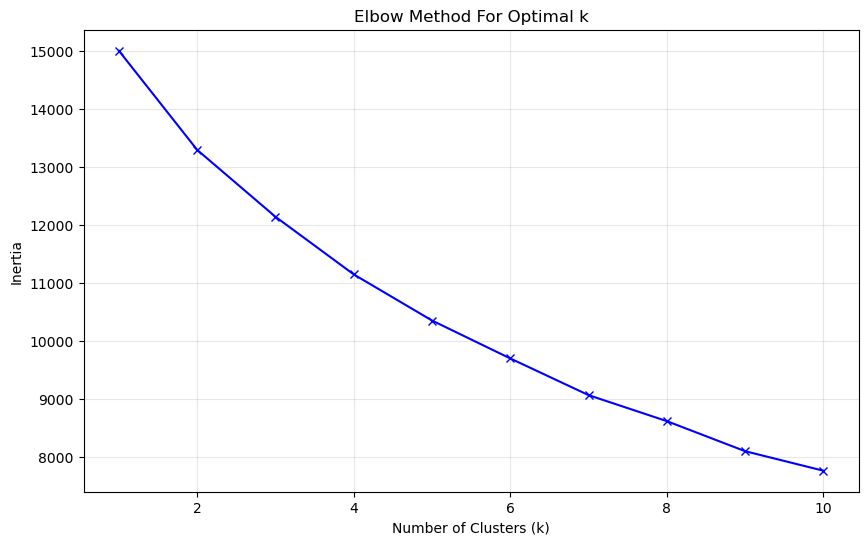

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

In [33]:
# Fit final model with chosen k value
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
movie2['Cluster'] = kmeans.fit_predict(X_scaled)

# Numeric characteristics
print("\nNumeric Characteristics by Cluster:")
print(movie2.groupby('Cluster')[movie3].mean().round(2))

# Cluster sizes
print("\nNumber of films per cluster:")
print(movie2['Cluster'].value_counts().sort_index())


Numeric Characteristics by Cluster:
         AvgRating  NumVotes  ReleaseYear   Decade  Genre_Action  \
Cluster                                                            
0             4.26  34573.37      2002.59  1997.65          0.41   
1             4.58  27546.14      2010.87  2006.55          0.04   
2             4.34  39456.55      2006.54  2002.16          0.33   
3             4.32  31129.84      2010.05  2005.88          0.11   
4             4.20  37854.34      2017.25  2013.65          0.64   

         Genre_Adventure  Genre_Comedy  Genre_Crime  Genre_Drama  \
Cluster                                                            
0                   0.36          0.75         0.17         0.08   
1                   0.02          0.03         0.06         0.22   
2                   0.26          0.35         0.09         0.16   
3                   0.03          0.65         0.03         0.47   
4                   0.25          0.15         0.25         0.61   

         

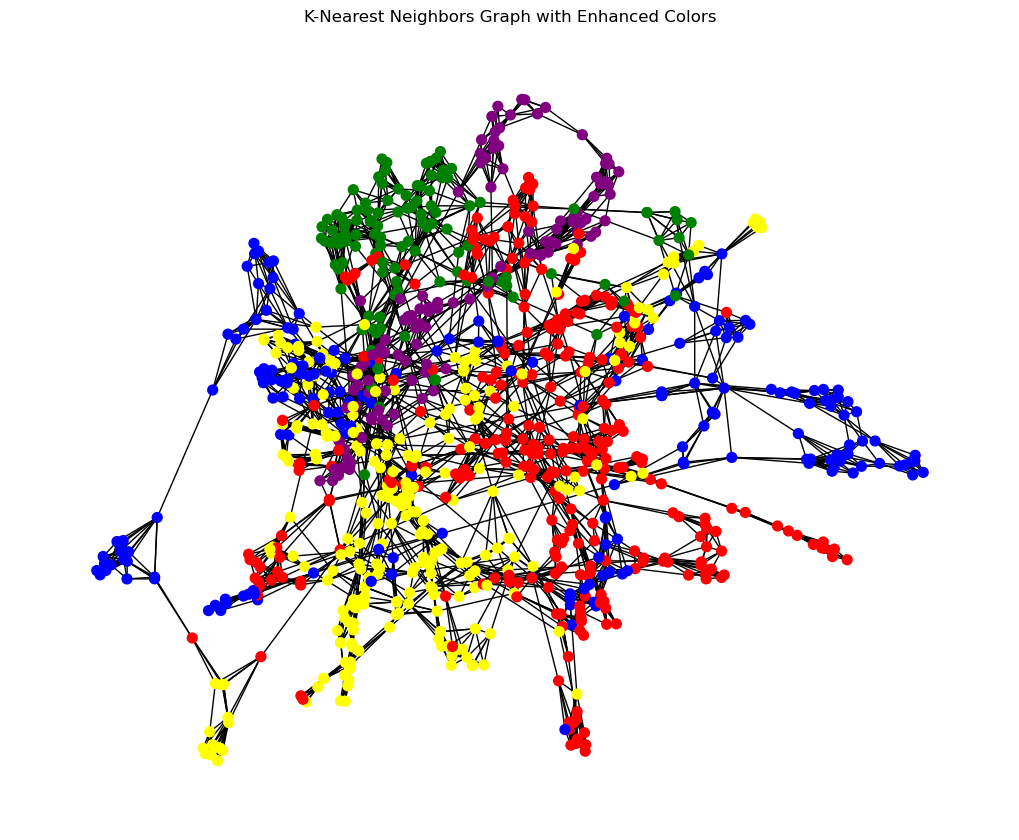

In [34]:
k = 5
knn_graph = kneighbors_graph(X_scaled, n_neighbors=k, mode='connectivity', include_self=False)

# turn to network map
G = nx.from_scipy_sparse_array(knn_graph)

custom_colors = ListedColormap(['red', 'blue', 'green', 'purple', 'yellow'])


plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  
nx.draw(
    G,
    pos,
    node_size=50,
    node_color=movie2['Cluster'],
    cmap=custom_colors, 
    with_labels=False
)
plt.title("K-Nearest Neighbors Graph with Enhanced Colors")
plt.show()

In [35]:
genre_columns = [col for col in movie3 if col.startswith("Genre_")] # show graph output
genre_distribution = movie2.groupby("Cluster")[genre_columns].mean()
print(genre_distribution)

         Genre_Action  Genre_Adventure  Genre_Comedy  Genre_Crime  \
Cluster                                                             
0            0.412903         0.361290      0.748387     0.170968   
1            0.035533         0.020305      0.025381     0.060914   
2            0.327586         0.258621      0.353448     0.094828   
3            0.105263         0.026316      0.649123     0.026316   
4            0.638783         0.250951      0.152091     0.247148   

         Genre_Drama  Genre_Fantasy  Genre_Horror  Genre_Mystery  \
Cluster                                                            
0           0.083871       0.000000      0.154839       0.016129   
1           0.223350       0.005076      0.878173       0.502538   
2           0.163793       1.000000      0.379310       0.086207   
3           0.473684       0.008772      0.008772       0.043860   
4           0.608365       0.000000      0.083650       0.060837   

         Genre_Romance  Genre_Sci-Fi  G


Genre Composition by Cluster:
         Genre_Action  Genre_Adventure  Genre_Comedy  Genre_Crime  \
Cluster                                                             
0            0.238095         0.028571      0.028571     0.038095   
1            0.829787         1.000000      0.000000     0.085106   
2            0.160714         0.000000      0.839286     0.000000   
3            0.020408         0.010204      0.020408     0.071429   
4            0.436170         0.000000      0.319149     0.000000   
5            0.090909         0.018182      0.672727     0.009091   
6            0.661538         0.015385      0.707692     1.000000   
7            0.343137         0.294118      0.401961     0.088235   
8            0.471910         0.022472      0.179775     0.011236   
9            0.346939         0.000000      0.081633     1.000000   
10           0.512195         1.000000      1.000000     0.000000   

         Genre_Drama  Genre_Fantasy  Genre_Horror  Genre_Mystery  \
Clu

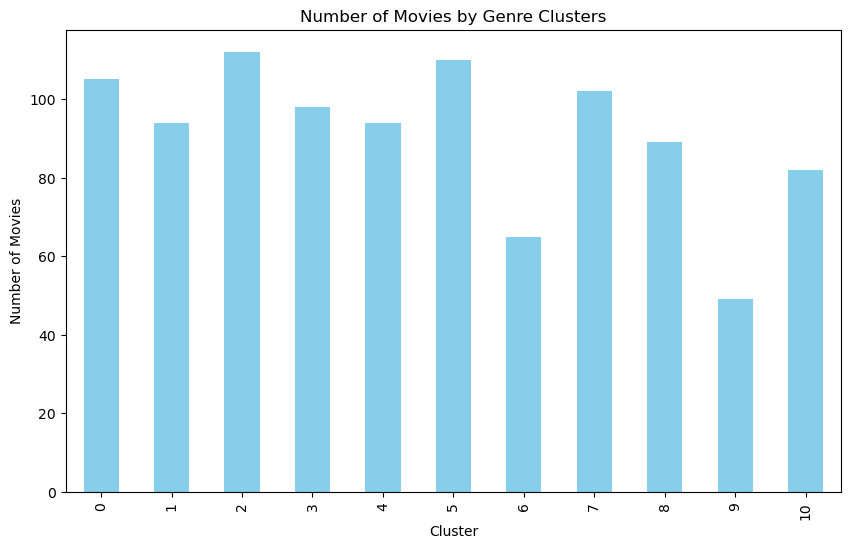

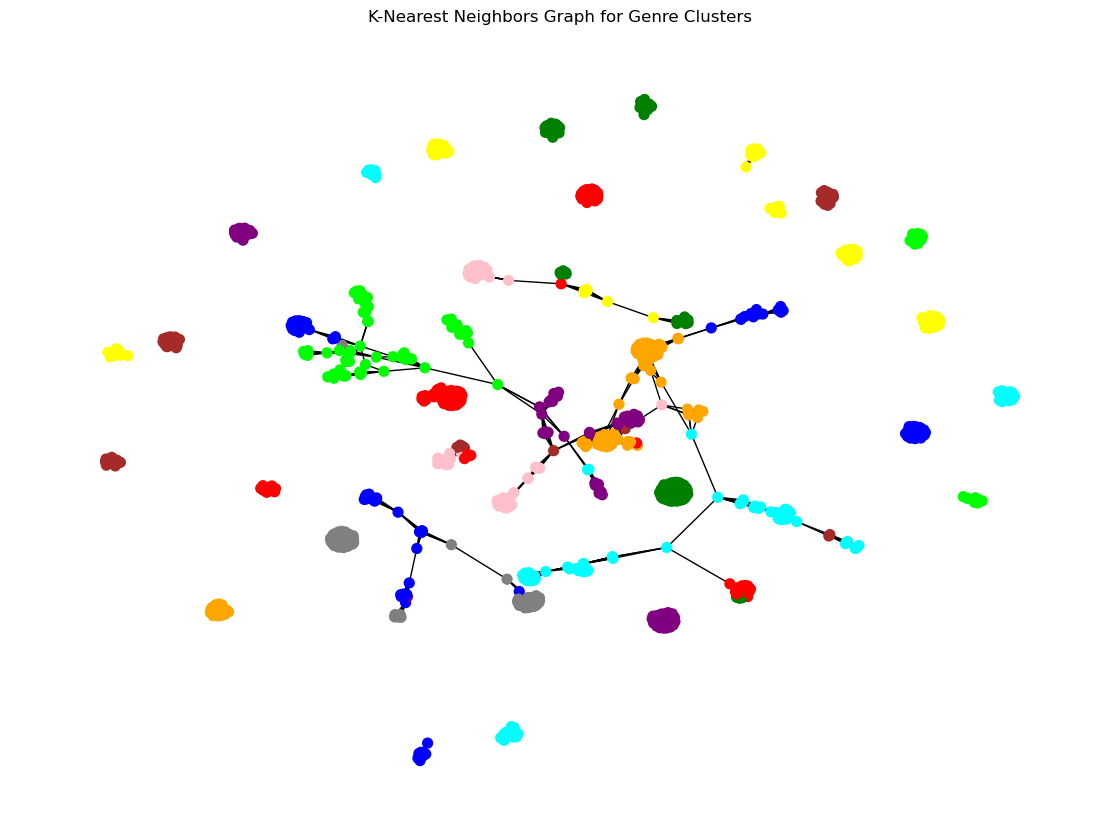

In [36]:
genre_features = movie2[genre_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(genre_features)

k = len(genre_columns)

kmeans = KMeans(n_clusters=k, random_state=42)
movie2['Cluster'] = kmeans.fit_predict(X_scaled)

# analyze the clusters/graph
print("\nGenre Composition by Cluster:")
genre_composition = movie2.groupby('Cluster')[genre_columns].mean()
print(genre_composition)

#grapgh showing the unplotted data 
plt.figure(figsize=(10, 6))
movie2['Cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Movies by Genre Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Movies')
plt.show()

knn_graph = kneighbors_graph(X_scaled, n_neighbors=5, mode='connectivity', include_self=False)
G = nx.from_scipy_sparse_array(knn_graph)

custom_colors = ListedColormap(['red', 'blue', 'green', 'purple', 'yellow', 
                                'orange', 'pink', 'cyan', 'lime', 'brown', 'gray'])

plt.figure(figsize=(11, 8))
pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    node_size=50,
    node_color=movie2['Cluster'],
    cmap=custom_colors,
    with_labels=False
)
plt.title("K-Nearest Neighbors Graph for Genre Clusters")
plt.show()


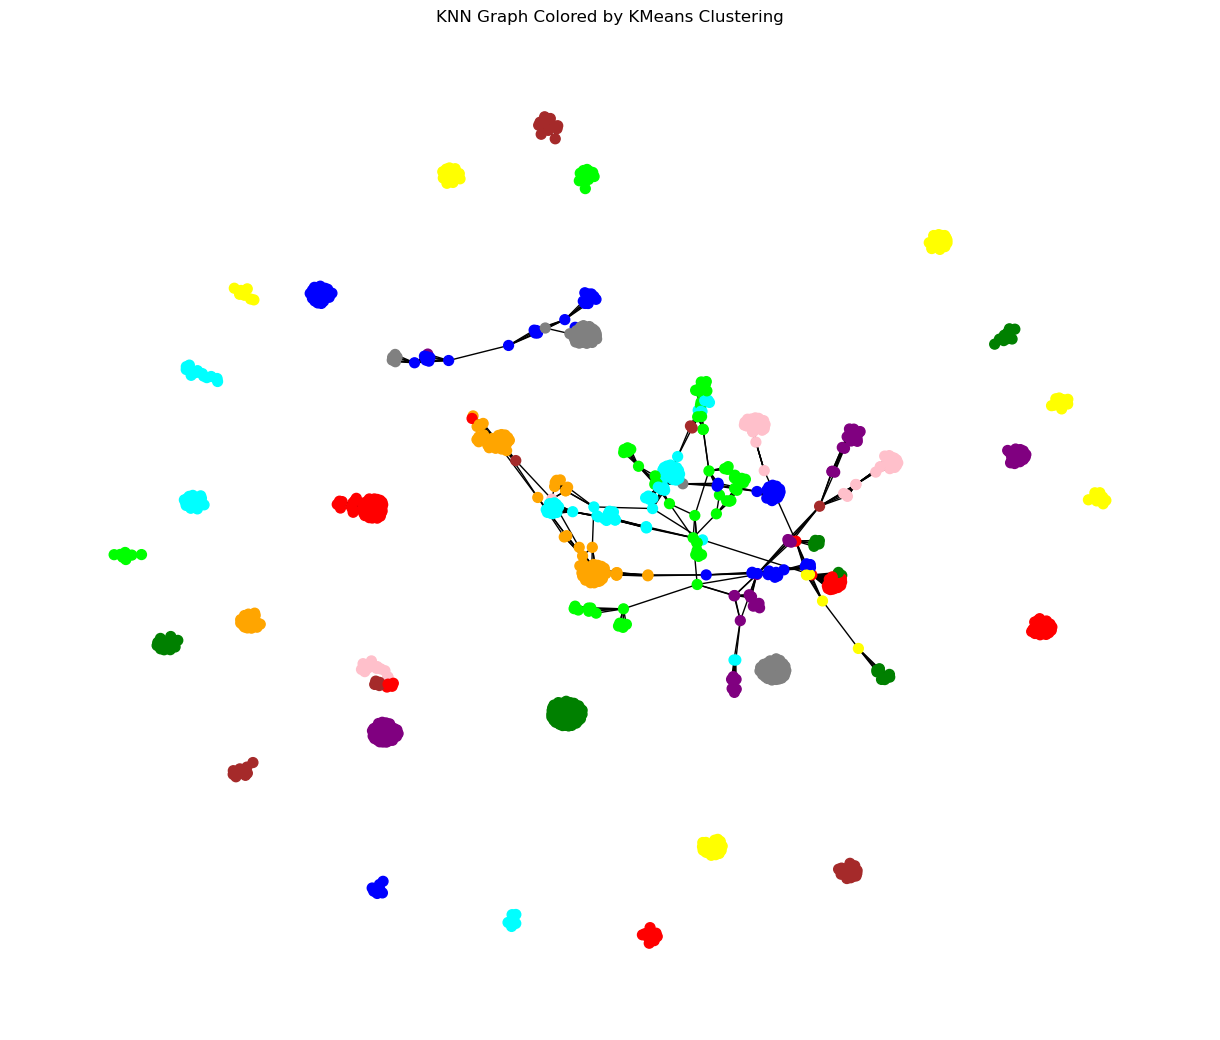

In [37]:
genre_features = movie2[genre_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(genre_features)

k = len(genre_columns)  # number of clusters is number of genres
kmeans = KMeans(n_clusters=k, random_state=42)
movie2['Cluster'] = kmeans.fit_predict(X_scaled)

k = 5 
knn_graph = kneighbors_graph(X_scaled, n_neighbors=k, mode='connectivity', include_self=False)

#trying out network map

custom_colors = ListedColormap(['red', 'blue', 'green', 'purple', 'yellow', 
                                'orange', 'pink', 'cyan', 'lime', 'brown', 'gray'])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)  
nx.draw(
    G,
    pos,
    node_size=50,
    node_color=movie2['Cluster'],
    cmap=custom_colors,  
    with_labels=False
)
plt.title("KNN Graph Colored by KMeans Clustering")
plt.show()



Dominant Genre for Each Cluster:
Cluster
0        Genre_Horror
1     Genre_Adventure
2        Genre_Comedy
3       Genre_Mystery
4         Genre_Drama
5       Genre_Romance
6         Genre_Crime
7       Genre_Fantasy
8        Genre_Sci-Fi
9         Genre_Crime
10    Genre_Adventure
dtype: object


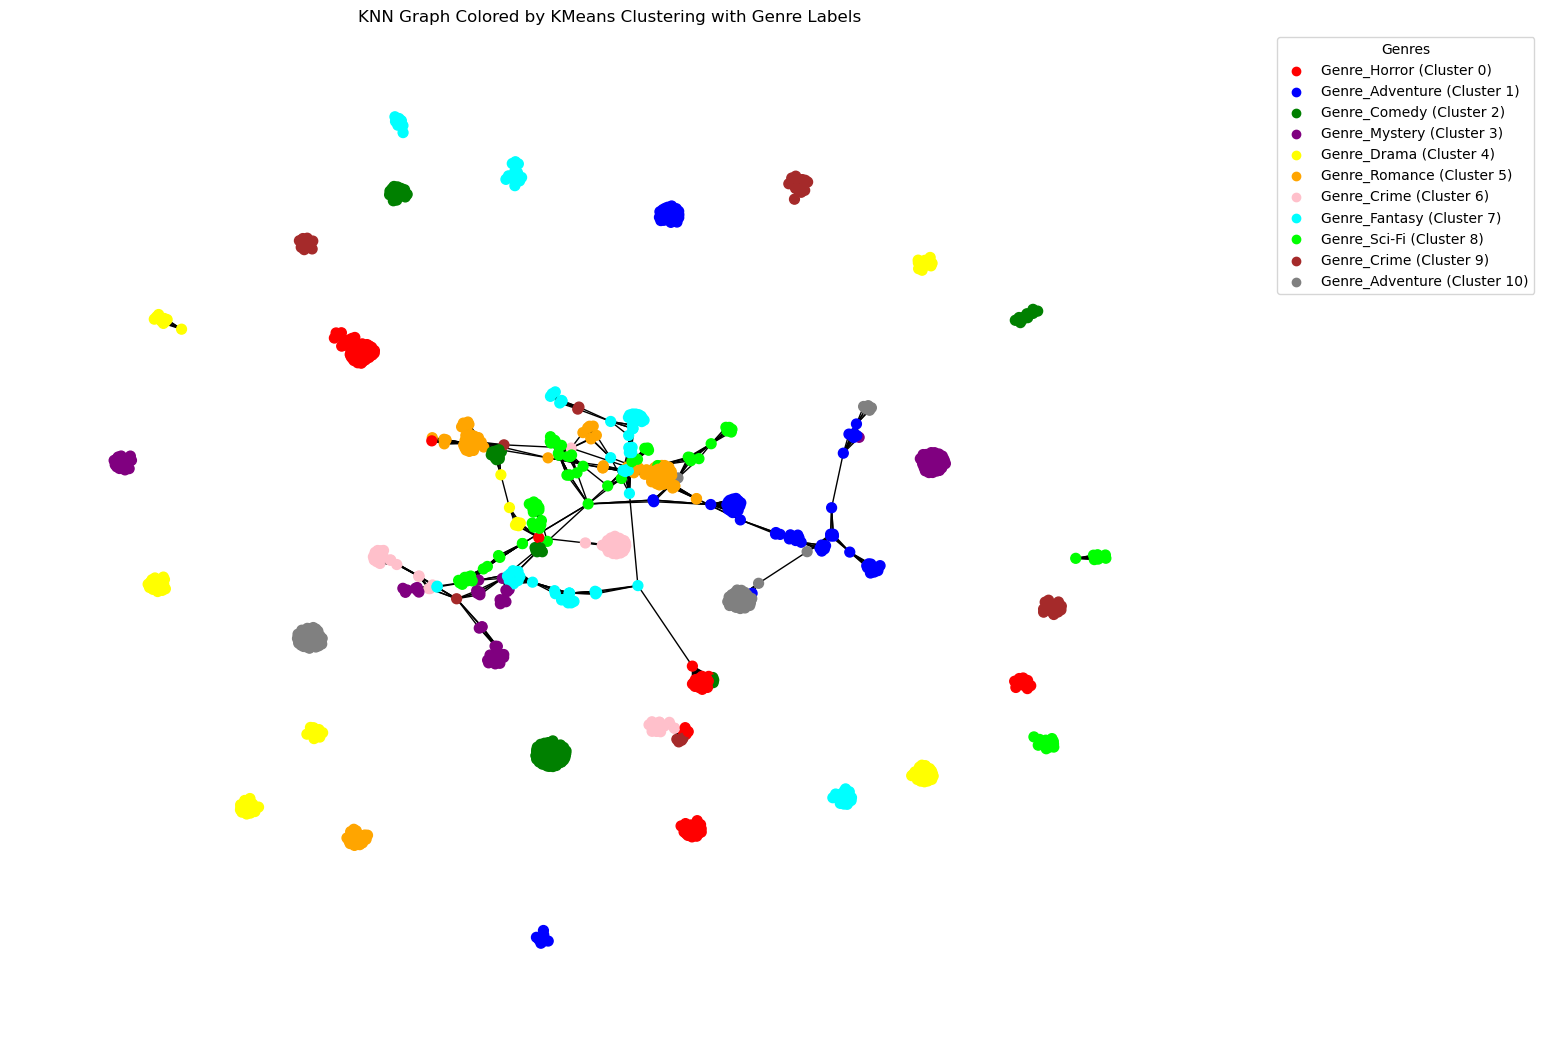

In [38]:
genre_features = movie2[genre_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(genre_features)

k = len(genre_columns)  # Number of clusters = number of genres
kmeans = KMeans(n_clusters=k, random_state=42)
movie2['Cluster'] = kmeans.fit_predict(X_scaled)

# choosing dominant cluster
cluster_genres = movie2.groupby('Cluster')[genre_columns].mean()
dominant_genres = cluster_genres.idxmax(axis=1)  # Get the dominant genre for each cluster
print("\nDominant Genre for Each Cluster:")
print(dominant_genres)

knn_graph = kneighbors_graph(X_scaled, n_neighbors=5, mode='connectivity', include_self=False)
G = nx.from_scipy_sparse_array(knn_graph)

custom_colors = ListedColormap(['red', 'blue', 'green', 'purple', 'yellow', 
                                'orange', 'pink', 'cyan', 'lime', 'brown', 'gray'])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)  
nx.draw(
    G,
    pos,
    node_size=50,
    node_color=movie2['Cluster'],  
    cmap=custom_colors, 
    with_labels=False
)

# color coded genres
for i, color in enumerate(custom_colors.colors[:k]):
    plt.scatter([], [], c=color, label=f"{dominant_genres[i]} (Cluster {i})")

plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("KNN Graph Colored by KMeans Clustering with Genre Labels")
plt.show()



Cluster Summary (AvgRating + Dominant Genre):
         AvgRating  Genre_Action  Genre_Adventure  Genre_Comedy  Genre_Crime  \
Cluster                                                                        
0         4.437500      0.000000         0.104167      0.166667     0.000000   
1         4.345455      0.090909         0.027273      0.663636     0.018182   
2         4.470755      0.528302         0.084906      0.471698     1.000000   
3         4.453521      0.577465         0.507042      0.070423     0.000000   
4         4.411111      0.626263         1.000000      0.757576     0.000000   
5         4.441176      0.070588         0.035294      0.035294     0.047059   
6         4.382353      0.343137         0.294118      0.382353     0.098039   
7         1.750000      0.181818         0.113636      0.454545     0.068182   
8         4.087097      0.983871         0.322581      0.112903     0.016129   
9         4.544828      0.189655         0.000000      0.922414     0.000

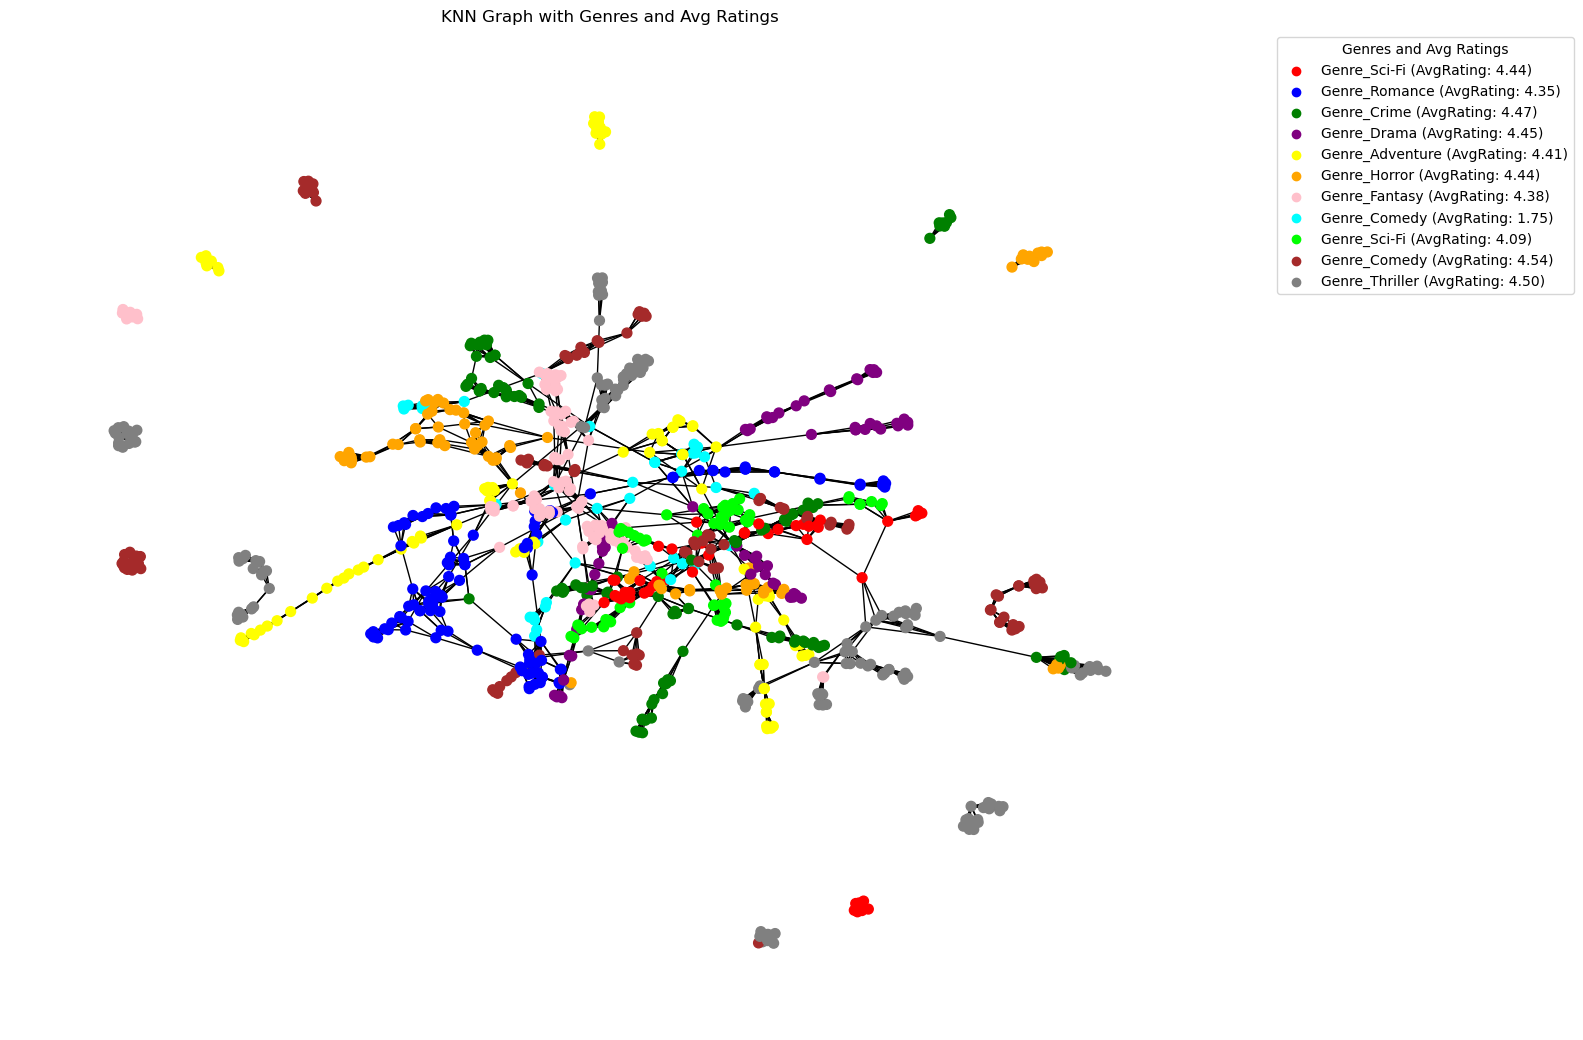

In [39]:
features = ['AvgRating'] + ['Genre_Action', 'Genre_Adventure', 'Genre_Comedy', 
                            'Genre_Crime', 'Genre_Drama', 'Genre_Fantasy', 
                            'Genre_Horror', 'Genre_Mystery', 'Genre_Romance', 
                            'Genre_Sci-Fi', 'Genre_Thriller']

cluster_features = movie2[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features)

k = len(features)
kmeans = KMeans(n_clusters=k, random_state=42)
movie2['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = movie2.groupby('Cluster').mean()[['AvgRating'] + features[1:]]
dominant_genres = cluster_summary[features[1:]].idxmax(axis=1)  # Get dominant genre per cluster

print("\nCluster Summary (AvgRating + Dominant Genre):")
print(cluster_summary)
print("\nDominant Genre for Each Cluster:")
print(dominant_genres)

k = 5  
knn_graph = kneighbors_graph(X_scaled, n_neighbors=k, mode='connectivity', include_self=False)
G = nx.from_scipy_sparse_array(knn_graph)

custom_colors = ListedColormap(['red', 'blue', 'green', 'purple', 'yellow', 
                                'orange', 'pink', 'cyan', 'lime', 'brown', 'gray'])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)  
nx.draw(
    G,
    pos,
    node_size=50,
    node_color=movie2['Cluster'], 
    cmap=custom_colors, 
    with_labels=False
)

for i, color in enumerate(custom_colors.colors[:kmeans.n_clusters]):
    plt.scatter([], [], c=color, label=f"{dominant_genres[i]} (AvgRating: {cluster_summary['AvgRating'][i]:.2f})")

plt.legend(title="Genres and Avg Ratings", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("KNN Graph with Genres and Avg Ratings")
plt.show()


In [41]:
node_index = 5  
print(movie2.iloc[node_index])  


AvgRating              1.1
NumVotes           11228.0
ReleaseYear         2022.0
Decade              2020.0
Genre_Action           1.0
Genre_Adventure        0.0
Genre_Comedy           0.0
Genre_Crime            0.0
Genre_Drama            1.0
Genre_Fantasy          0.0
Genre_Horror           0.0
Genre_Mystery          0.0
Genre_Romance          0.0
Genre_Sci-Fi           0.0
Genre_Thriller         0.0
Cluster                7.0
Name: 5, dtype: float64



Cluster Summary (AvgRating + Dominant Genres):
         AvgRating  Genre_Action  Genre_Adventure  Genre_Comedy  Genre_Crime  \
Cluster                                                                        
0         4.322167      0.635468         1.000000      0.428571     0.000000   
1         4.212357      0.308924         0.000000      0.405034     0.000000   
2         4.382222      0.555556         0.066667      0.377778     1.000000   
3         4.686607      0.026786         0.008929      0.026786     0.062500   
4         4.319469      0.097345         0.017699      0.654867     0.017699   

         Genre_Drama  Genre_Fantasy  Genre_Horror  Genre_Mystery  \
Cluster                                                            
0           0.206897       0.147783      0.123153       0.004926   
1           0.297483       0.146453      0.372998       0.000000   
2           0.348148       0.081481      0.081481       0.125926   
3           0.267857       0.098214      0.785714  

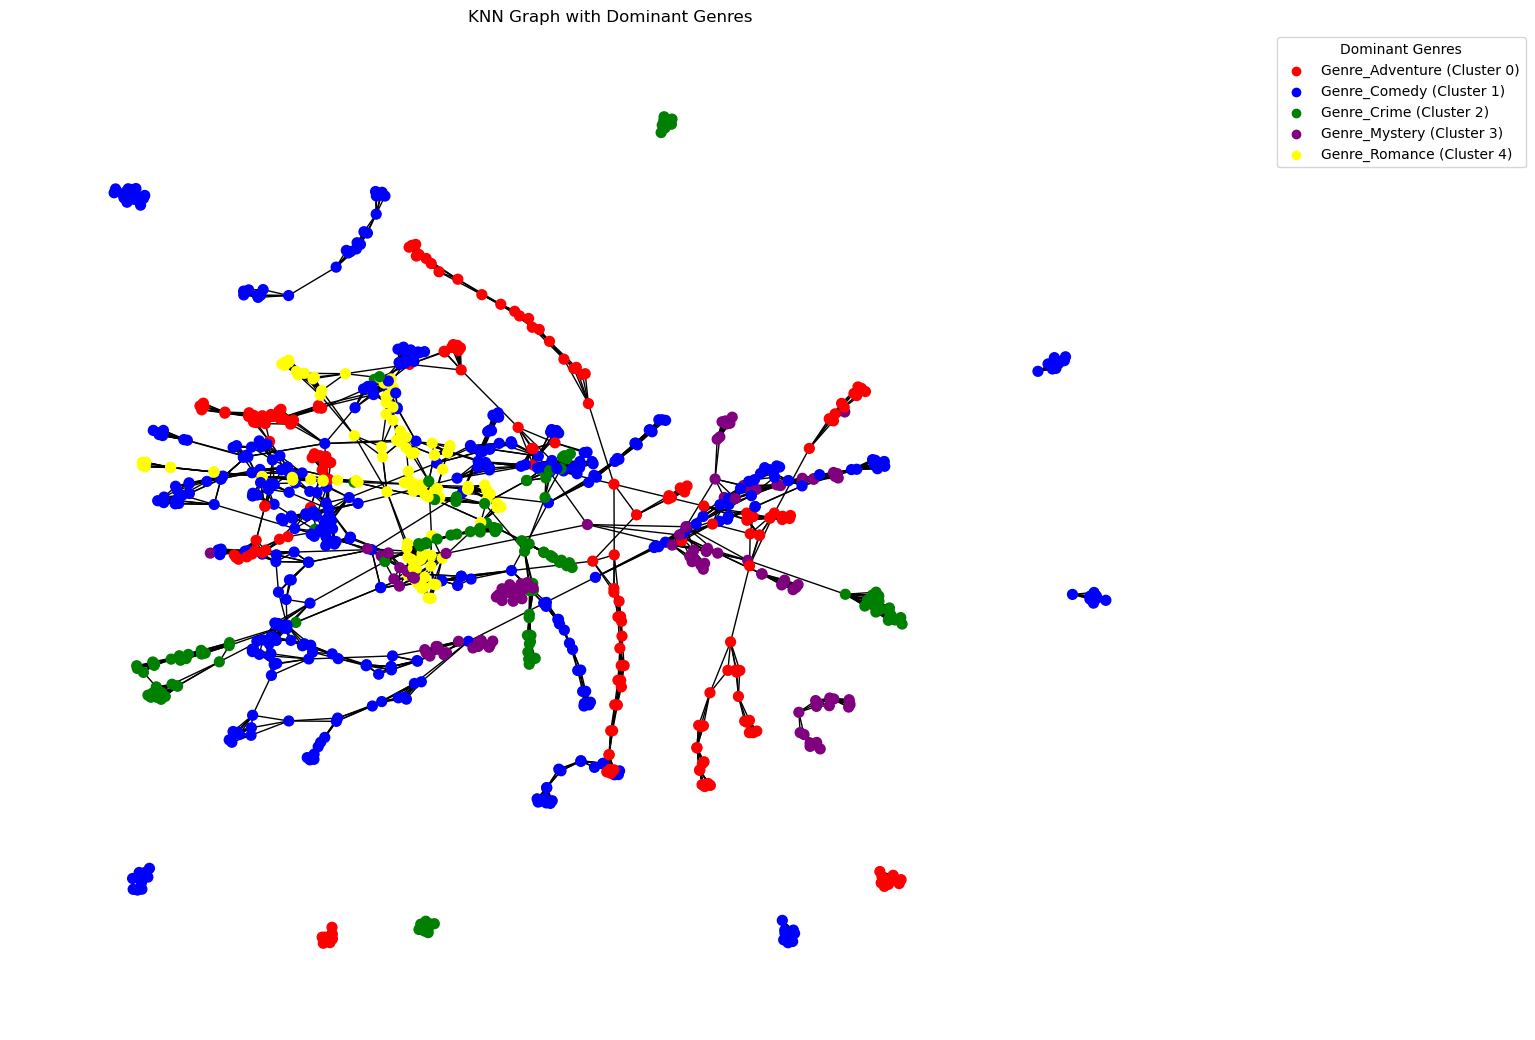

In [42]:
features = ['AvgRating'] + [col for col in movie2.columns if col.startswith('Genre_')]

cluster_features = movie2[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features)

k = 5  
kmeans = KMeans(n_clusters=k, random_state=42)
movie2['Cluster'] = kmeans.fit_predict(X_scaled)

# dominant genre for each cluster
genre_columns = [col for col in movie2.columns if col.startswith('Genre_')]
cluster_summary = movie2.groupby('Cluster').mean()[['AvgRating'] + genre_columns]
dominant_genres = cluster_summary[genre_columns].idxmax(axis=1)

print("\nCluster Summary (AvgRating + Dominant Genres):")
print(cluster_summary)
print("\nDominant Genre for Each Cluster:")
print(dominant_genres)

knn_graph = kneighbors_graph(X_scaled, n_neighbors=5, mode='connectivity', include_self=False)
G = nx.from_scipy_sparse_array(knn_graph)

custom_colors = ListedColormap(['red', 'blue', 'green', 'purple', 'yellow'])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    node_size=50,
    node_color=movie2['Cluster'],  
    cmap=custom_colors,
    with_labels=False
)

for i, color in enumerate(custom_colors.colors[:k]):
    plt.scatter([], [], c=color, label=f"{dominant_genres[i]} (Cluster {i})")

plt.legend(title="Dominant Genres", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("KNN Graph with Dominant Genres")
plt.show()


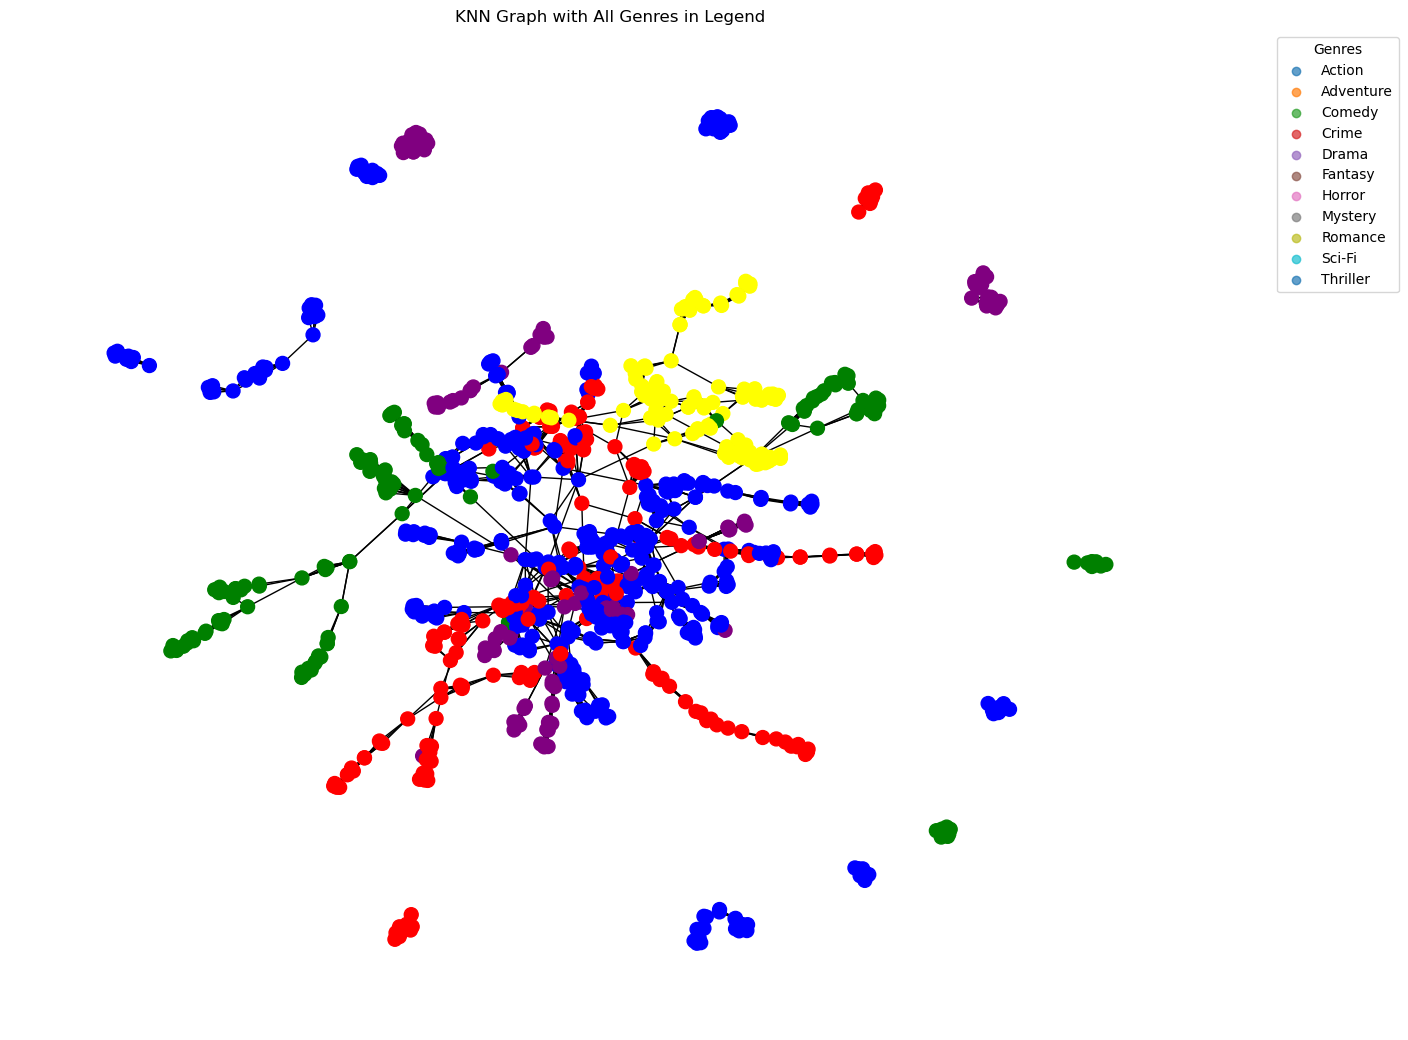

In [43]:
# Create a legend entry for every genre
genres = [col for col in movie2.columns if col.startswith('Genre_')]

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    node_size=100,  # Increase node size
    node_color=movie2['Cluster'],
    cmap=custom_colors,
    with_labels=False
)

# Add legend entries for all genres
for i, genre in enumerate(genres):
    plt.scatter([], [], label=genre.replace('Genre_', ''), alpha=0.7)

plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("KNN Graph with All Genres in Legend")
plt.show()


<Axes: xlabel='Cluster', ylabel='Genre_Action'>

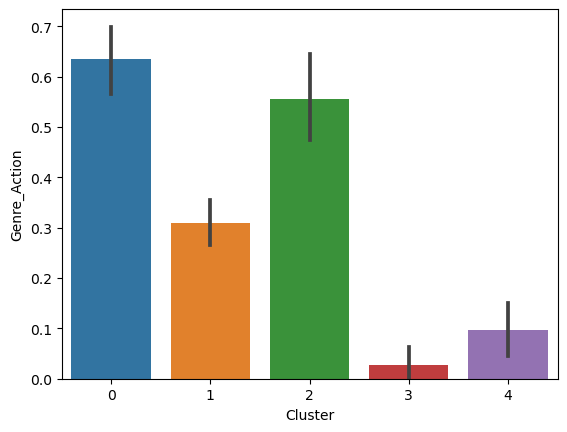

In [44]:
sns.barplot(x=movie2['Cluster'], y=movie2['Genre_Action'])

<Axes: xlabel='Cluster', ylabel='Genre_Sci-Fi'>

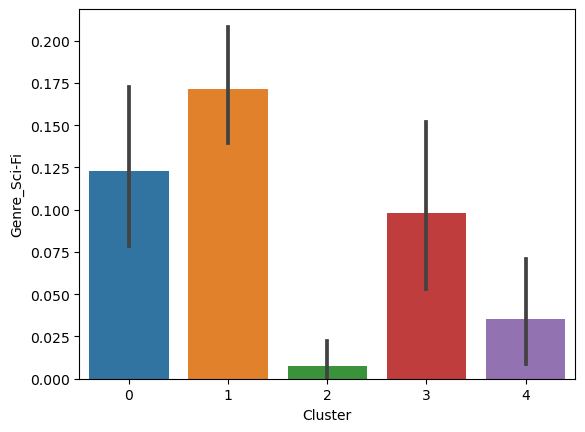

In [45]:
sns.barplot(x=movie2['Cluster'], y=movie2['Genre_Sci-Fi'])

[Text(0.5, 0, 'Number of Films'), Text(0, 0.5, 'Cluster')]

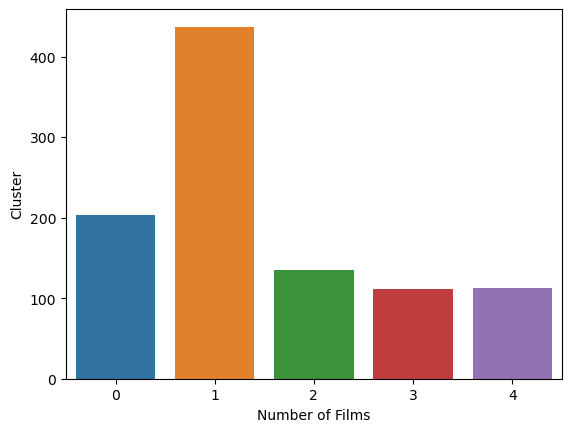

In [46]:
ax = sns.barplot(x=movie2['Cluster'], y=sum(movie2['Cluster']==x for x in movie2['Cluster']))
ax.set(xlabel='Number of Films', ylabel='Cluster')